# MTA Analysis For SoftBank Robotics

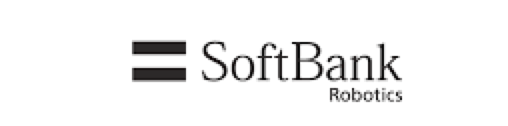

# Imports

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from functools import partial, reduce
from sqlalchemy import create_engine
import datetime
from sqlite3 import connect


# Loading Data

In [175]:
!pwc

/bin/bash: pwc: command not found


In [77]:
def get_data(week_nums):
    link = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_link = link.format(week_num)
        dfs.append(pd.read_csv(file_link))
    return pd.concat(dfs)
        
week_nums = [210807, 210814, 210821, 210828, 210904, 210911, 210918, 210925, 211002, 211009, 211030]
data_df = get_data(week_nums)
data_df.to_csv("D:\\data.csv", index=False)

In [78]:
engine=create_engine("sqlite://", echo=False)
data_df.to_sql('data', con=engine)

In [80]:
df=pd.read_sql('SELECT * FROM data group by STATION order by ENTRIES limit 10 ', engine)
df

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,125465,PTH17,R541,01-00-00,THIRTY THIRD ST,1,PTH,07/31/2021,00:47:54,REGULAR,0,0
1,46804,N012,R035,01-05-00,168 ST,AC1,IND,07/31/2021,00:00:00,REGULAR,46,0
2,159962,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,07/31/2021,01:00:00,REGULAR,108,866
3,131596,R106,R305,01-00-00,WTC-CORTLANDT,1,IRT,07/31/2021,01:00:00,REGULAR,144,139
4,45094,N001,R173,01-05-00,INWOOD-207 ST,A,IND,07/31/2021,01:00:00,REGULAR,593,0
5,17482,B023,R211,01-05-00,KINGS HWY,BQ,BMT,07/31/2021,00:00:00,REGULAR,892,0
6,109247,N547,R420,01-04-00,DITMAS AV,F,IND,07/31/2021,01:00:00,REGULAR,922,0
7,91121,N338,R128,01-05-00,SUTPHIN BLVD,F,IND,07/31/2021,01:00:00,REGULAR,1769,0
8,91541,N339,R114,01-05-00,PARSONS BLVD,F,IND,07/31/2021,00:00:00,REGULAR,2026,0
9,128533,PTH22,R540,00-00-00,PATH NEW WTC,1,PTH,07/31/2021,01:08:09,REGULAR,2792,13021


In [132]:
data_df.columns = [column.strip() for column in data_df.columns]
data_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [134]:
data_df=data_df[["C/A","STATION","DATE","TIME","ENTRIES",'EXITS']]

In [135]:
data_df.head()

,C/A,STATION,DATE,TIME,ENTRIES,EXITS
0,A002,59 ST,07/31/2021,00:00:00,7611181,2603110
1,A002,59 ST,07/31/2021,04:00:00,7611192,2603113
2,A002,59 ST,07/31/2021,08:00:00,7611197,2603126
3,A002,59 ST,07/31/2021,12:00:00,7611235,2603178
4,A002,59 ST,07/31/2021,16:00:00,7611357,2603211


In [136]:
data_df.columns

Index(['C/A', 'STATION', 'DATE', 'TIME', 'ENTRIES', 'EXITS'], dtype='object')

In [83]:
data_df.describe()

,ENTRIES,EXITS
count,2.306607e+06,2.306607e+06
mean,4.140971e+07,3.324654e+07
std,2.181569e+08,1.922147e+08
min,0.000000e+00,0.000000e+00
25%,2.223600e+05,1.057260e+05
50%,1.389328e+06,8.470890e+05
75%,5.989386e+06,3.976198e+06
max,2.147395e+09,2.133797e+09


In [137]:
print('Number of instances = %d' % (data_df.shape[0])) #row
print('Number of attributes = %d' % (data_df.shape[1])) #column

Number of instances = 2306607
Number of attributes = 6


In [138]:
cols_data = pd.DataFrame(data_df.dtypes)
num_cols = list(cols_data[cols_data[0]=='int64'].index)
cat_cols = list(cols_data[cols_data[0]=='object'].index)
print('Numeric variables includes:','\n',num_cols)
print('\nCategorical variables includes','\n',cat_cols)

Numeric variables includes: 
 ['ENTRIES', 'EXITS']

Categorical variables includes 
 ['C/A', 'STATION', 'DATE', 'TIME']


# Data Cleaning



In [85]:
data_df.isna()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
209879,False,False,False,False,False,False,False,False,False,False,False
209880,False,False,False,False,False,False,False,False,False,False,False
209881,False,False,False,False,False,False,False,False,False,False,False
209882,False,False,False,False,False,False,False,False,False,False,False


In [139]:
data_df.isna().sum()

C/A        0
STATION    0
DATE       0
TIME       0
ENTRIES    0
EXITS      0
dtype: int64

# Duplicate Data

In [124]:

#print('\nNumber of rows before discarding duplicates = %d' % (data_df.shape[0]))

In [125]:
#dup = data_df.ENTRIES.duplicated().sum()
#print('\nNumber of duplicate rows = %d' % (dup))

In [140]:
dups = data_df.duplicated().sum()
print('\nNumber of duplicate rows = %d' % (dups))
print('\nNumber of rows before discarding duplicates = %d' % (data_df.shape[0]))
data_df2= data_df.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data_df2.shape[0])) 


Number of duplicate rows = 10

Number of rows before discarding duplicates = 2306607
Number of rows after discarding duplicates = 2306597


In [127]:
#data_df2= data_df.ENTRIES.drop_duplicates()
#print('Number of rows after discarding duplicates = %d' % (data_df2.shape[0])) 

In [141]:
for i,v in enumerate(cat_cols):
    data_df2[v].str.strip()

In [142]:
i=data_df2[(data_df2['ENTRIES']==0) | (data_df2['EXITS']==0)].index
data_df3=data_df2.drop(i)

# Outlier

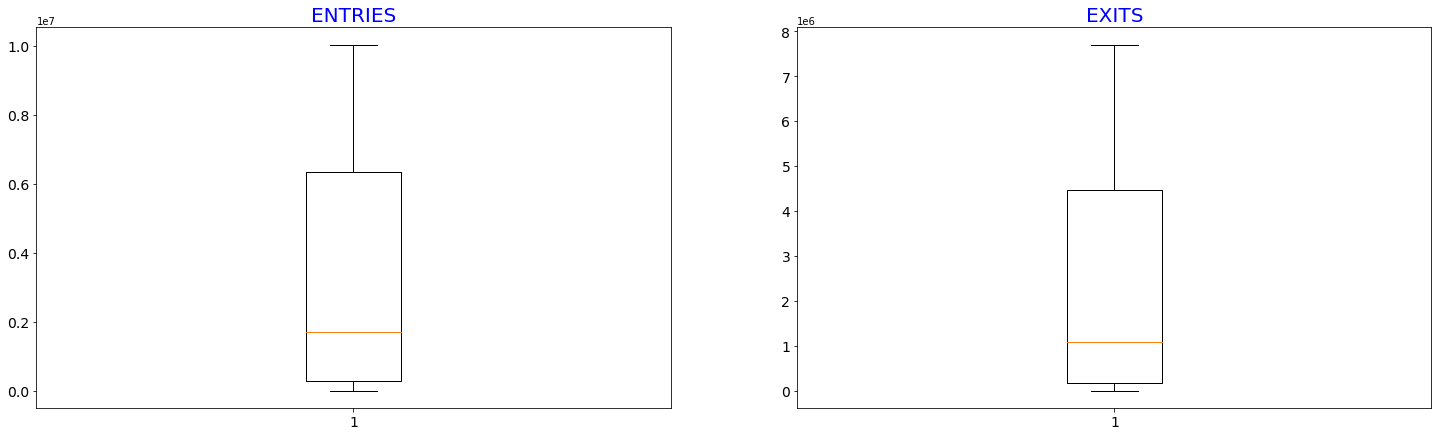

<ipython-input-152-bd37cd55c75d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3['ENTRIES']= winsorize(data_df3['ENTRIES'],(0,0.15))
<ipython-input-152-bd37cd55c75d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3['EXITS'] = winsorize(data_df3['EXITS'],(0,0.15))


In [152]:
num_feat = data_df3.select_dtypes(include=['int64']).columns
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.boxplot(data_df3[num_feat[i]])
    plt.title(num_feat[i],color="b",fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

plt.show()  
data_df3['ENTRIES']= winsorize(data_df3['ENTRIES'],(0,0.15))
data_df3['EXITS'] = winsorize(data_df3['EXITS'],(0,0.15))
plt.rcParams['figure.figsize'] = (25,7)
baslik_font = {'family':'arial','color':'purple','weight':'bold','size':25}
col_list=['ENTRIES', 'EXITS']

# Aggregation

In [154]:
data_df3["DATE_TIME"] = pd.to_datetime(data_df3.DATE + " " +data_df3.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
data_df3['MONTH'] = data_df3['DATE_TIME'].dt.month

<ipython-input-154-cb4453ed9fe3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3["DATE_TIME"] = pd.to_datetime(data_df3.DATE + " " +data_df3.TIME,
<ipython-input-154-cb4453ed9fe3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3['MONTH'] = data_df3['DATE_TIME'].dt.month


In [155]:
data_df3['DAY_WEEK'] = data_df3[['DATE_TIME']]\
    .apply(lambda x: datetime.datetime.strftime(x['DATE_TIME'], '%A'), axis=1)

<ipython-input-155-c061f5f2533b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3['DAY_WEEK'] = data_df3[['DATE_TIME']]\


In [156]:
data_df3['Entry_Inc'] = abs(data_df3.ENTRIES.diff())
data_df3['Exits_Inc'] = abs(data_df3.EXITS.diff())
data_df3['TOTAL_TRAFFIC'] = np.add(data_df3.Entry_Inc, data_df3.Exits_Inc)

<ipython-input-156-9b5dcdeb276b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3['Entry_Inc'] = abs(data_df3.ENTRIES.diff())
<ipython-input-156-9b5dcdeb276b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df3['Exits_Inc'] = abs(data_df3.EXITS.diff())
<ipython-input-156-9b5dcdeb276b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [157]:
# filter outliers above specified quantile
quant_filt = 0.99
q = data_df3["Entry_Inc"].quantile(quant_filt)
data_df3 = data_df3[data_df3["Entry_Inc"] < q]

r = data_df3["Exits_Inc"].quantile(quant_filt)
data_df3 = data_df3[data_df3["Exits_Inc"] < r]

s = data_df3["TOTAL_TRAFFIC"].quantile(quant_filt)
data_df3 = data_df3[data_df3["TOTAL_TRAFFIC"] < s]

data_df3 = data_df3.dropna() # apparently no issues with NaN cells; running as best practice

data_df3.head()

,C/A,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH,DAY_WEEK,Entry_Inc,Exits_Inc,TOTAL_TRAFFIC
1,A002,59 ST,07/31/2021,04:00:00,7611192,2603113,2021-07-31 04:00:00,7,Saturday,11.0,3.0,14.0
2,A002,59 ST,07/31/2021,08:00:00,7611197,2603126,2021-07-31 08:00:00,7,Saturday,5.0,13.0,18.0
3,A002,59 ST,07/31/2021,12:00:00,7611235,2603178,2021-07-31 12:00:00,7,Saturday,38.0,52.0,90.0
4,A002,59 ST,07/31/2021,16:00:00,7611357,2603211,2021-07-31 16:00:00,7,Saturday,122.0,33.0,155.0
5,A002,59 ST,07/31/2021,20:00:00,7611512,2603241,2021-07-31 20:00:00,7,Saturday,155.0,30.0,185.0


In [158]:
sample=data_df3.loc[data_df3.MONTH==9]
sample

,C/A,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH,DAY_WEEK,Entry_Inc,Exits_Inc,TOTAL_TRAFFIC
24,A002,59 ST,09/01/2021,00:00:00,7628030,2609899,2021-09-01 00:00:00,9,Wednesday,83.0,21.0,104.0
25,A002,59 ST,09/01/2021,04:00:00,7628037,2609904,2021-09-01 04:00:00,9,Wednesday,7.0,5.0,12.0
26,A002,59 ST,09/01/2021,08:00:00,7628051,2609949,2021-09-01 08:00:00,9,Wednesday,14.0,45.0,59.0
27,A002,59 ST,09/01/2021,12:00:00,7628112,2610083,2021-09-01 12:00:00,9,Wednesday,61.0,134.0,195.0
28,A002,59 ST,09/01/2021,16:00:00,7628256,2610111,2021-09-01 16:00:00,9,Wednesday,144.0,28.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...
210200,TRAM2,RIT-ROOSEVELT,09/30/2021,05:00:00,5554,649,2021-09-30 05:00:00,9,Thursday,0.0,0.0,0.0
210201,TRAM2,RIT-ROOSEVELT,09/30/2021,09:00:00,5554,649,2021-09-30 09:00:00,9,Thursday,0.0,0.0,0.0
210202,TRAM2,RIT-ROOSEVELT,09/30/2021,13:00:00,5554,649,2021-09-30 13:00:00,9,Thursday,0.0,0.0,0.0
210203,TRAM2,RIT-ROOSEVELT,09/30/2021,17:00:00,5554,649,2021-09-30 17:00:00,9,Thursday,0.0,0.0,0.0


# Visualiztion

In [161]:
df1=sample.groupby(['STATION'])['TOTAL_TRAFFIC'].sum().sort_values(ascending=False).reset_index().head(10)
df1

,STATION,TOTAL_TRAFFIC
0,34 ST-PENN STA,1743842.0
1,GRD CNTRL-42 ST,1629897.0
2,TIMES SQ-42 ST,1377438.0
3,23 ST,1354993.0
4,34 ST-HERALD SQ,1328113.0
5,14 ST-UNION SQ,1322685.0
6,86 ST,1268022.0
7,59 ST,1196579.0
8,PATH NEW WTC,1136274.0
9,FULTON ST,1061720.0


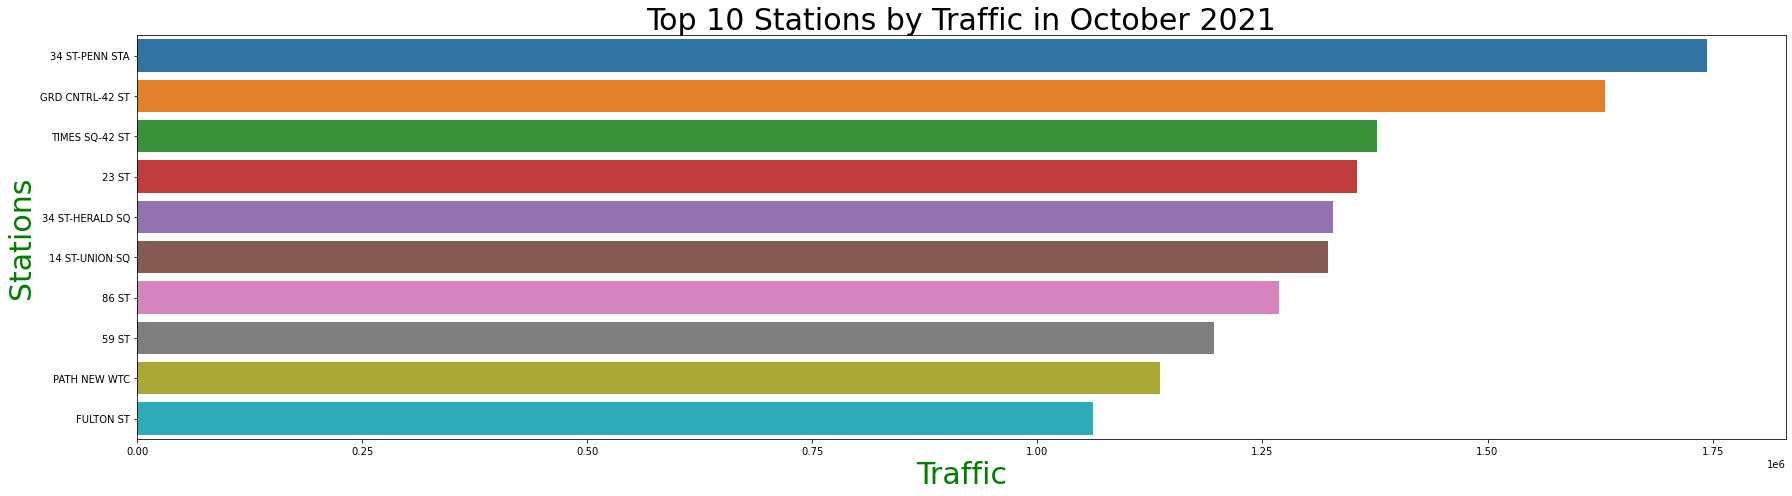

In [169]:
ax = sns.barplot(x="TOTAL_TRAFFIC", y='STATION', data=df1)

plt.xlabel('Traffic',color="g",fontsize=30)
plt.ylabel('Stations', color="g", fontsize=30)
plt.title("Top 10 Stations by Traffic in October 2021", fontsize=30)
plt.tight_layout()
plt.show()

In [170]:
df2=sample.groupby(['DAY_WEEK'])['TOTAL_TRAFFIC'].sum().sort_values(ascending=False).reset_index()
df2

,DAY_WEEK,TOTAL_TRAFFIC
0,Wednesday,13614901.0
1,Thursday,12670046.0
2,Tuesday,10940680.0
3,Friday,10681389.0
4,Monday,9798759.0
5,Saturday,6653399.0
6,Sunday,6509990.0


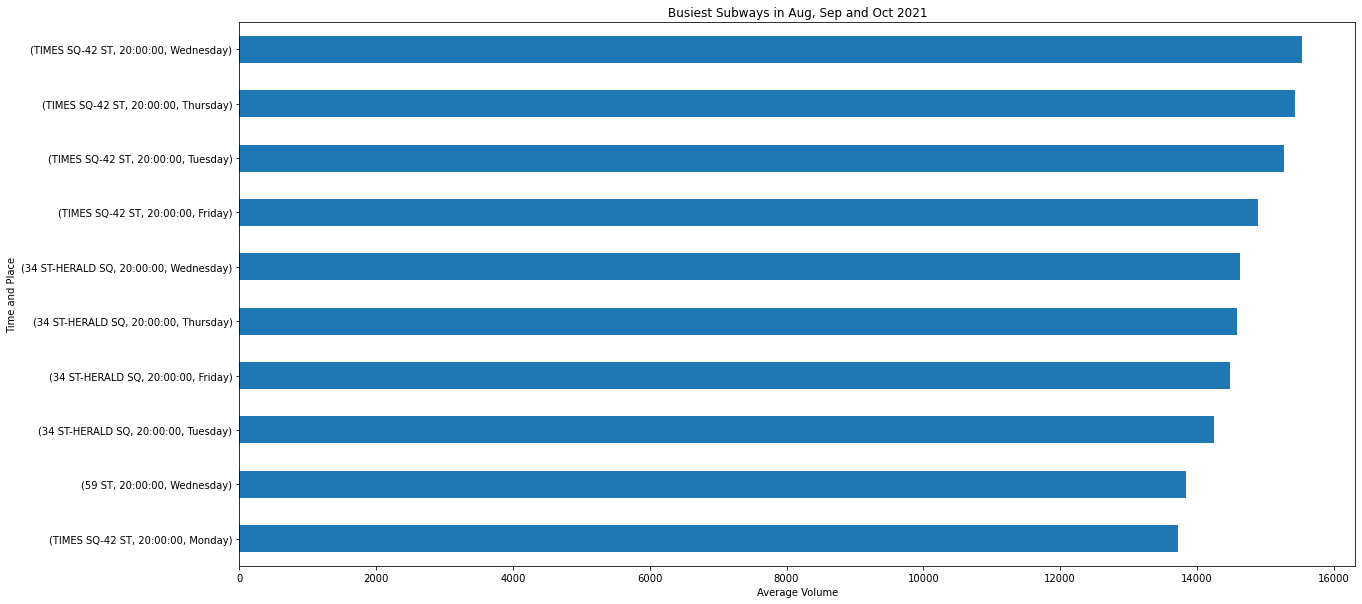

In [173]:
def recommendation_chart(df):
    df_pre = df[['STATION', 'DATE_TIME', 'TOTAL_TRAFFIC', 'DAY_WEEK', 'TIME']].copy()
    
    df1 = df_pre.groupby(['STATION','DATE_TIME','TIME','DAY_WEEK'])\
    .sum()\
    .reset_index()\
    .groupby(['STATION', 'TIME', 'DAY_WEEK'])\
    .mean()\
    .sort_values(by='TOTAL_TRAFFIC', ascending=False)
    
    fig, ax = plt.subplots(figsize=(20,10))
    df1[:10]['TOTAL_TRAFFIC'].sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_xlabel('Average Volume')
    ax.set_ylabel('Time and Place')
    ax.set_title('Busiest Subways in Aug, Sep and Oct 2021')
    
recommendation_chart(data_df3)